<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is a starter notebook for the guided project [Transfer Learning for NLP with TensorFlow Hub](https://www.coursera.org/projects/transfer-learning-nlp-tensorflow-hub/)

A complete version of this notebook is available in the course resources.

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, you will use pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

### Learning Objectives

By the time you complete this project, you will be able to:

- Use various pre-trained NLP text embedding models from TensorFlow Hub
- Perform transfer learning to fine-tune models on your own text data
- Visualize model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: TensorFlow Hub for Natural Language Processing
- **[Task 5]()**: Define Function to Build and Compile Models
- **[Task 6]()**: Define Function to Build and Compile Models(Continued...)
- **[Task 7]()**: Train Various Text Classification Models
- **[Task 8]()**: Compare Accuracy and Loss Curves
- **[Task 9]()**: Fine-tuning Models from TF Hub
- **[Task 10]()**: Train Bigger Models and Visualize Metrics with TensorBoard

## Task 2: Setup your TensorFlow and Colab Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [2]:
!nvidia-smi

Fri Jun 25 23:17:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.5.0
Hub version:  0.12.0
GPU is available


## Task 3: Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle project/Quora Insincere Questions Classification/quora-insincere-questions-classification/train.csv', low_memory= False)

In [5]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df.shape

(1306122, 3)

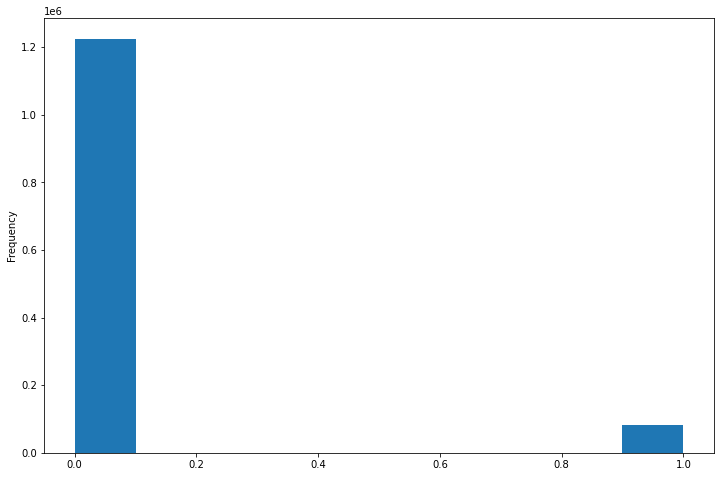

In [7]:
plt.figure()
df['target'].plot(kind = 'hist')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.01, stratify = df.target.values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.1,stratify = remaining.target.values)

In [9]:
train_df.shape, valid_df.shape

((13061, 3), (129306, 3))

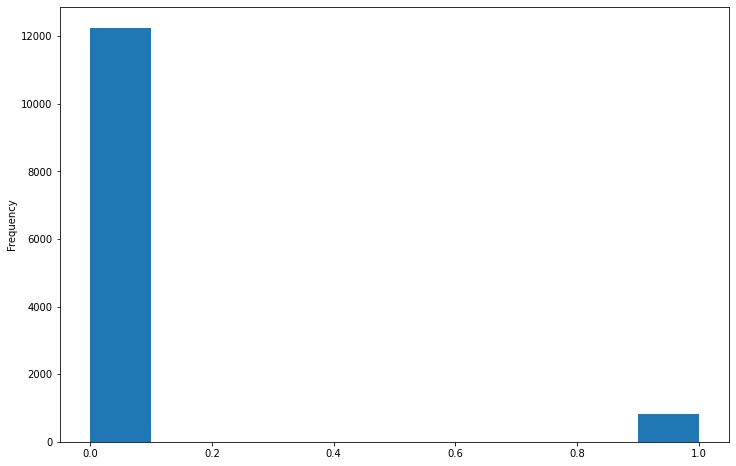

In [10]:
train_df['target'].plot(kind = 'hist')

## Task 4: TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

You can think of a question vector as a distributed representation of a question, and is computed for every question in the training set. The question vector along with the output label is then used to train the statistical classification model. 

The intuition is that the question vector captures the semantics of the question and, as a result, can be effectively used for classification. 

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP: 
* word-based representations and 
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

In [11]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Tasks 5 & 6: Define Function to Build and Compile Models

In [12]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape = [],
                             output_shape = [embed_size],
                             dtype = tf.string,
                             trainable = trainable)
  model = tf.keras.Sequential([
                               hub_layer,
                               tf.keras.layers.Dense(256, activation = 'relu'),
                               tf.keras.layers.Dense(64, activation = 'relu'),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')]
                              )
  model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001),
                loss = tf.losses.BinaryCrossentropy(),
                metrics = [tf.metrics.BinaryAccuracy(name = 'accuracy')]
                )
  model.summary()
  history = model.fit(train_df['question_text'],train_df['target'],
                      epochs = 100,
                      batch_size = 32,
                      validation_data = (valid_df['question_text'],valid_df['target']),
                      callbacks = [tfdocs.modeling.EpochDots(),
                                   tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min'),
                                   tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose = 0
                      )
  return history


## Task 7: Train Various Text Classification Models

### Task 7.1: Train gnews-swivel-20dim Models

In [13]:
histories ={}

In [14]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [15]:
histories['gnews-swivel-20dim'] = train_and_evaluate_model(module_url, 20, 'gnews-swivel-20dim', trainable=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 421,909
Trainable params: 21,889
Non-trainable params: 400,020
_________________________________________________________________



Epoch: 0, accuracy:0.9380,  loss:0.2511,  val_accuracy:0.9382,  val_loss:0.1929,  
...........

### Task 7.2: Train nnlm-en-dim50 Models

In [16]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [17]:
histories['nnlm-en-dim50'] = train_and_evaluate_model(module_url, 50, 'nnlm-en-dim50', trainable=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 48,220,169
Trainable params: 29,569
Non-trainable params: 48,190,600
_________________________________________________________________



Epoch: 0, accuracy:0.8842,  loss:0.3791,  val_accuracy:0.9381,  val_loss:0.2302,  
.................

### Task 7.3: Train nnlm-en-dim128 Models

In [18]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [19]:
histories['nnlm-en-dim128'] = train_and_evaluate_model(module_url, 128, 'nnlm-en-dim128', trainable=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________



Epoch: 0, accuracy:0.9062,  loss:0.3438,  val_accuracy:0.9381,  val_loss:0.2187,  
.............

### Task 7.4: Train universal-sentence-encoder Models

In [20]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [21]:
histories['universal-sentence-encoder'] = train_and_evaluate_model(module_url, 512, 'universal-sentence-encoder', trainable=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________



Epoch: 0, accuracy:0.9375,  loss:0.2945,  val_accuracy:0.9381,  val_loss:0.1705,  
...........

### Task 7.5: Train universal-sentence-encoder-large Models

In [22]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [23]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, 512, 'universal-sentence-encoder-large', trainable=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________



Epoch: 0, accuracy:0.9330,  loss:0.2988,  val_accuracy:0.9381,  val_loss:0.1585,  
.........

## Task 8: Compare Accuracy and Loss Curves

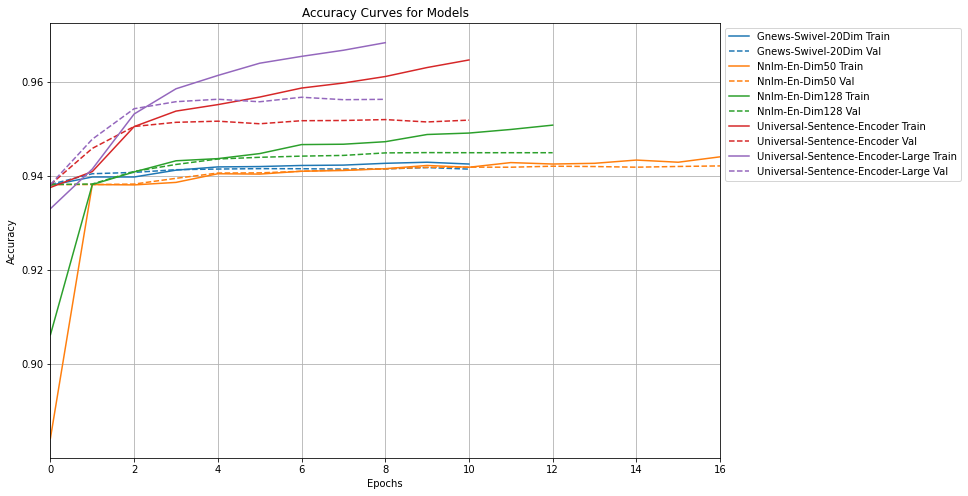

In [24]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

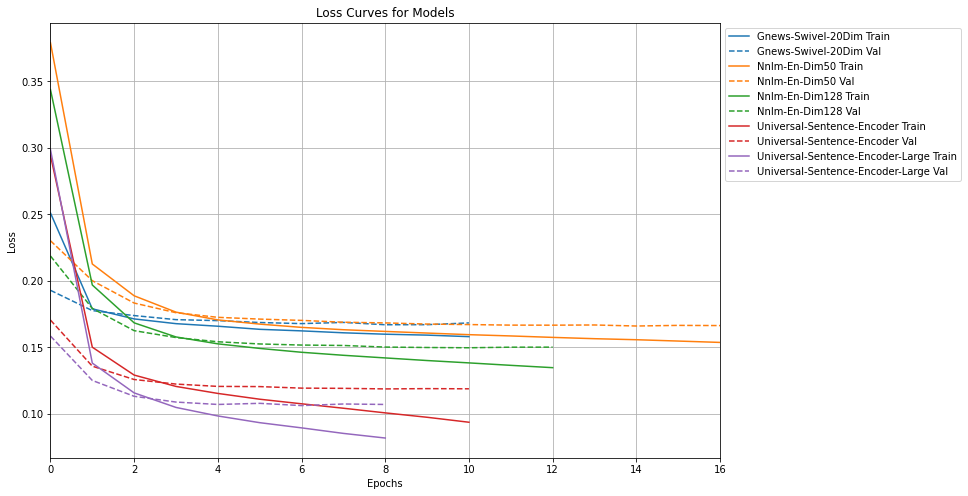

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 9: Fine-tune Model from TF Hub

### Task 9.1: Train gnews-swivel-20dim Models

In [26]:
histories ={}

In [27]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [28]:
histories['gnews-swivel-20dim'] = train_and_evaluate_model(module_url, 20, 'gnews-swivel-20dim', trainable=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9172,  loss:0.2765,  val_accuracy:0.9381,  val_loss:0.1939,  
..............

### Task 9.2: Train nnlm-en-dim50 Models

In [29]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [30]:
histories['nnlm-en-dim50'] = train_and_evaluate_model(module_url, 50, 'nnlm-en-dim50', trainable=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 48,220,169
Trainable params: 48,220,169
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9322,  loss:0.3229,  val_accuracy:0.9381,  val_loss:0.2185,  
.......

### Task 9.3: Train nnlm-en-dim128 Models

In [31]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [32]:
histories['nnlm-en-dim128'] = train_and_evaluate_model(module_url, 128, 'nnlm-en-dim128', trainable=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 124,692,225
Trainable params: 124,692,225
Non-trainable params: 0
_________________________________________________________________


Exception ignored in: <function CapturableResource.__del__ at 0x7fa143acf830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 277, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 933, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 764, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 3050, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/e


Epoch: 0, accuracy:0.9235,  loss:0.3098,  val_accuracy:0.9381,  val_loss:0.2010,  
.....

### Task 9.4: Train universal-sentence-encoder Models

In [33]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [34]:
histories['universal-sentence-encoder'] = train_and_evaluate_model(module_url, 512, 'universal-sentence-encoder', trainable=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 256,945,665
Trainable params: 256,945,665
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9404,  loss:0.2223,  val_accuracy:0.9488,  val_loss:0.1346,  
....

### Task 9.5: Train universal-sentence-encoder-large Models

In [35]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [36]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, 512, 'universal-sentence-encoder-large', trainable=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,502,721
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9441,  loss:0.1773,  val_accuracy:0.9544,  val_loss:0.1101,  
...

Compare Accuracy and Loss Curves

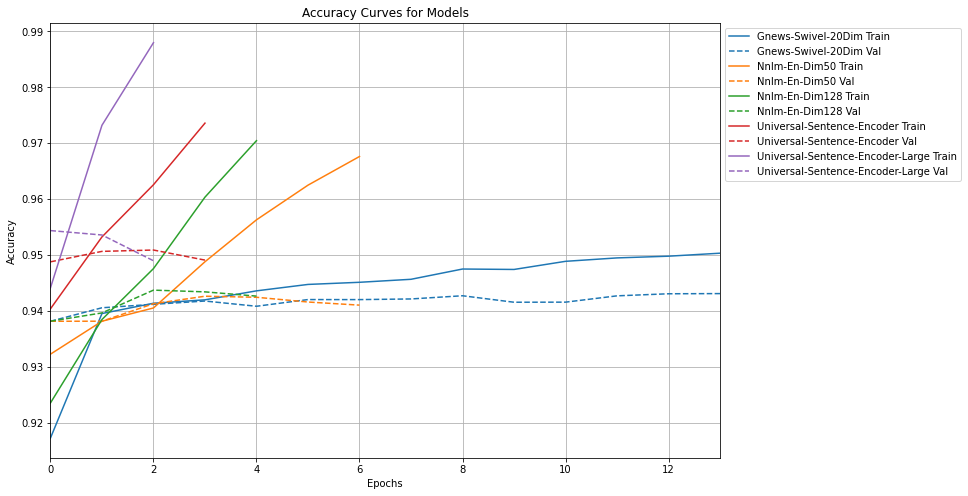

In [37]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

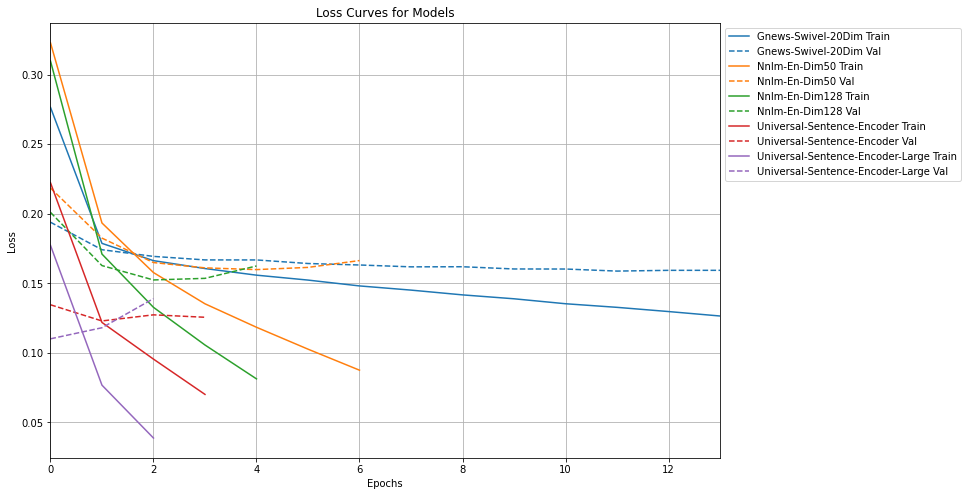

In [38]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 10: Train Bigger Models and Visualize Metrics with TensorBoard

In [41]:
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle project/Quora Insincere Questions Classification/quora-insincere-questions-classification/test.csv')

In [42]:
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [43]:
sample_sub = pd.read_csv('/content/drive/MyDrive/Kaggle project/Quora Insincere Questions Classification/quora-insincere-questions-classification/sample_submission.csv')
sample_sub

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [45]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [47]:
hub_layer = hub.KerasLayer(module_url, input_shape = [],
                            output_shape = 512,
                            dtype = tf.string,
                            trainable = True)
model = tf.keras.Sequential([
                              hub_layer,
                              tf.keras.layers.Dense(256, activation = 'relu'),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, activation = 'sigmoid')]
                            )
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001),
              loss = tf.losses.BinaryCrossentropy(),
              metrics = [tf.metrics.BinaryAccuracy(name = 'accuracy')]
              )
model.summary()
history = model.fit(train_df['question_text'],train_df['target'],
                    epochs = 100,
                    batch_size = 32,
                    validation_data = (valid_df['question_text'],valid_df['target']),
                    callbacks = [tfdocs.modeling.EpochDots(),
                                  tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min'),
                                  tf.keras.callbacks.TensorBoard(logdir/'universal-sentence-encoder')],
                    verbose = 0
                    )


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 512)               256797824 
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 256,945,665
Trainable params: 256,945,665
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9401,  loss:0.2283,  val_accuracy:0.9487,  val_loss:0.1332,  
.....

In [48]:
prediction = model.predict(test_df['question_text'])

In [49]:
prediction

array([[0.44975784],
       [0.00045953],
       [0.00093116],
       ...,
       [0.00052163],
       [0.0007316 ],
       [0.00922313]], dtype=float32)

In [50]:
prediction = np.where(prediction>0.5,1,0 )
prediction

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [51]:
submission = sample_sub.copy()
submission['prediction'] = prediction

In [52]:
submission.to_csv('/content/drive/MyDrive/Kaggle project/Quora Insincere Questions Classification/submission_1.csv', index = False)